In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# %matplotlib widget


In [2]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from collections import OrderedDict
from itertools import product
from itertools import groupby
import itertools
import pickle
import glob
import chardet
import copy
from natsort import natsorted

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
# Set a professional style for the plot
plt.style.use('seaborn')
import matplotlib.dates as mdaates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace, Stream
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
from scipy.stats import norm, kstest, skew, kurtosis
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")


# Local Imports
from energy.utils_general import *
from energy.utils_energy import *
from energy.preprocessing import *
from energy.metrics import *
from picking.p_picking import p_picking_each

C:\Users\simon\AppData\Local\Temp\ipykernel_7776\2070167379.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


A tener en consideración. Las rutas a los archivos están guardadas de la siguiente forma: *waveform_M/event_ID/channel/station/eventid_canal_horainicio_horatermino.mseed*


# 1. Creamos un diccionario con las coordenadas de las estaciones del litoral a partir del archivo csv com las estaciones.

In [36]:
v_P = 8.064
file_stations_coord = os.path.join("BD paper", "catalogos","Estaciones_Chile.csv")
df = pd.read_csv(file_stations_coord, sep=';')
stations_coord_all = df.set_index('Station')[['Latitude', 'Longitude']].apply(tuple, axis=1).to_dict()
stations_names = list(stations_coord_all.keys())

# 2. Trabajar con la base de datos

### 2.1. La función all_channel_dict entrega un nested dictionary donde la primera capa de llaves indica el rango de magnitud, la segunda capa el ID evento, la tercera la red de la estación que la captó, y finalmente el valor es la traza ya leída por obspy

In [4]:
# Get the path to all the folders from the folder BD paper that is in the current directory
folders = glob.glob(os.path.join('BD paper', '*'))
# Get all the folders in the BD paper folder that start with waveform 
folders_signals = [folder for folder in folders if folder.startswith(os.path.join('BD paper', 'waveform'))]
folders_signals = sorted(folders_signals)

In [5]:
folders_signals

['BD paper\\waveform_1-2.9',
 'BD paper\\waveform_3p1',
 'BD paper\\waveform_3p2',
 'BD paper\\waveform_4p1',
 'BD paper\\waveform_4p2',
 'BD paper\\waveform_5',
 'BD paper\\waveform_6-9']

Esta función se puede/debe optimizar. Usando os.walk probablemente sale más rápido. No sé si existe alguna forma de hacerla más generalizable eso si

In [6]:
#inventory_path = "inventory"
inventory_path = os.path.join('BD paper', 'stations_xml1')
def all_channels_dict(folders_signals, inventory_path=inventory_path):

    result_dict = OrderedDict()

    for folder in folders_signals:
        waveform_type = os.path.split(folder)[-1]
        events_id = natsorted(glob.glob(os.path.join(folder, '*')))

        for event_id in events_id:
            events_name = os.path.split(event_id)[-1]
            network_path = glob.glob(os.path.join(event_id, '*'))

            for network_folder in network_path:
                network_name = os.path.split(network_folder)[-1]
                
                stations_path = glob.glob(os.path.join(network_folder, '*'))

                for station_path in stations_path:
                    stations_names = os.path.split(station_path)[-1]
                    #ic(stations_names)
                    stations_path = glob.glob(os.path.join(station_path, '*'))
                    #ic(stations_path)

                    # Get the channels for each station
                    stations_ch_z = [station_z for station_z in stations_path if 'BHZ' in station_z]
                    stations_ch_e = [station_e for station_e in stations_path if 'BHE' in station_e]
                    stations_ch_n = [station_n for station_n in stations_path if 'BHN' in station_n]

                    # if len(stations_ch_e) == 0 or len(stations_ch_n) == 0:
                    #     break
                    
                    traces = []

                    # Files to remove response
                    file_response = glob.glob(os.path.join(inventory_path, f"{stations_names}.xml"))
                    
                    if file_response:
                        remove_file = file_response[0]
                    

                    trace = read(stations_ch_z[0])

                    if len(stations_ch_e) > 0:
                        trace += read(stations_ch_e[0])
                    if len(stations_ch_n) > 0:
                        trace += read(stations_ch_n[0])

                    tr_resp = trace.copy()
                    #ic(len(tr_resp))
                    for i in range(len(tr_resp)):
                        try:
                            st_removed = remove_response(tr_resp.select(channel=tr_resp[i].stats.channel)[0], remove_file , 'obspy')
                            tr_resp[i] = st_removed
                        except:
                            ic(station_path)
                            #ic(tr_resp[i].stats.station)
                            pass

                    tr_filtered = tr_resp.copy()
                    tr_filtered.filter('bandpass', freqmin=4.0, freqmax=10.0)
                    traces.append(tr_filtered)

                    result_dict.setdefault(waveform_type, {}).setdefault(events_name, {}).setdefault(network_name, {}).setdefault(stations_names, traces)


    return result_dict

event_dict = all_channels_dict(folders_signals)

- CX: PB11
- C: ROC1
- C1: TA02, AC05, VA05

Lo que hice por ahora fue subirle 10 años al endDate para que no me tire error. A ROC1 le baje 10 años al startDate.

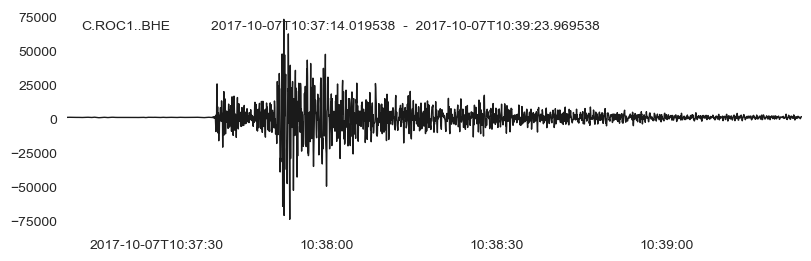

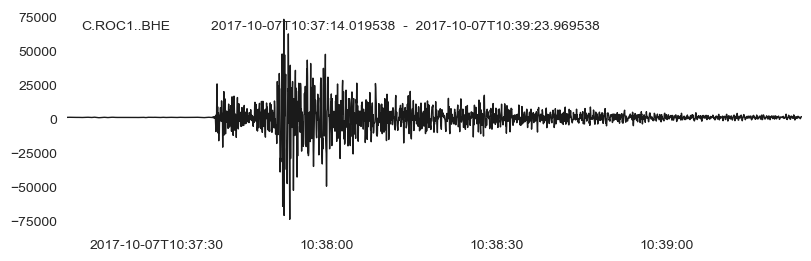

In [85]:
tr_path = 'BD paper/waveform_4p1/5159607/C/ROC1'
stations_path = glob.glob(os.path.join(tr_path, '*'))
remove_file = 'BD paper/stations_xml1/PB11.xml'

trace = read(stations_path[0])
trace += read(stations_path[1])
trace += read(stations_path[2])
tr_resp = trace.copy()
tr_resp[0].plot()

In [8]:
for i in range(len(tr_resp)):

    # if tr_resp[i].stats.station in ['PB11', 'TA02','AC05', 'ROC1', 'VA05']:
    #     ic(remove_file)
    #     ic(station_path)
    #     break
    #ic(tr_resp[i].stats.station)
    try:
        st_removed = remove_response(tr_resp.select(channel=tr_resp[i].stats.channel)[0], remove_file , 'obspy')
        tr_resp[i] = st_removed
    except:
        ic(tr_resp[i].stats.station)

ic| tr_resp[i].stats.station: 'ROC1'
ic| tr_resp[i].stats.station: 'ROC1'
ic| tr_resp[i].stats.station: 'ROC1'


In [10]:
waveform_type = list(event_dict.keys())

# get all the events ids consideting waveform type is a list. And make events_ids a dictionary with the waveform type as keys
events_ids = {waveform_type: [int(event_id) for event_id in event_dict[waveform_type].keys()] for waveform_type in waveform_type}


### 2.2. La siguiente función pone a todas las traces de TODOS los eventos en una lista.

In [11]:
def get_all_traces(nested_dict):
    traces = []
    for value in nested_dict.values():
        if isinstance(value, dict):
            traces.extend(get_all_traces(value))
        else:
            traces.extend(value)
    return traces

all_traces = get_all_traces(event_dict)

### 2.3 El siguiente código es para crear un nuevo archivo CSV que contenga solo los siguientes datos:
- EventId
- Time
- Latitud
- Longitud
- Magnitud
- Estación (la que aparece automáticamente en el catálogo)
- Estaciones más cercanas (calculada con geodisic. Cantidad arbitraria)

In [40]:
# Get all the csv files in the BD paper folder that have the word "cercanos" in their name
files_raw = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*descargados*.csv')))
files_raw

['BD paper\\catalogos\\Eventos_descargados_1-2.9.csv',
 'BD paper\\catalogos\\Eventos_descargados_3p1.csv',
 'BD paper\\catalogos\\Eventos_descargados_3p2.csv',
 'BD paper\\catalogos\\Eventos_descargados_4p1.csv',
 'BD paper\\catalogos\\Eventos_descargados_4p2.csv',
 'BD paper\\catalogos\\Eventos_descargados_5.csv',
 'BD paper\\catalogos\\Eventos_descargados_6-9.csv']

In [13]:
def filter_csv(files_raw, events_ids):
    # Columnas a mantener
    columns_to_keep = ["#EventID", "Time", "Latitude", "Longitude", "Magnitude", "Estacion"]

    for i, (waveform_type, event_ids) in enumerate(events_ids.items()):
        # Leer el archivo CSV
        df = pd.read_csv(files_raw[i], sep=';')

        # Filtrar las filas donde '#EventID' está en event_ids
        df = df[df['#EventID'].isin(event_ids)]

        # Ordernar la columna de #EventID
        df = df.sort_values(by='#EventID')

        # Mantener solo las columnas deseadas
        df = df[columns_to_keep]

        # Guardar el nuevo DataFrame en un nuevo archivo CSV
        df.to_excel(os.path.join("BD paper", "catalogos", f"{waveform_type}_filtered.xlsx"), index=False)

filter_csv(files_raw, events_ids)


### 2.4. Ahora que ya se tienen archivos .csv con columnas "Event"Time", "Magnitud", "Estación", "Latitud", "Longitud", podemos verificar efectivamente cuál es la estación más cercana y agregarla como última columna

In [14]:
files_filtered = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*filtered*')))
files_filtered

['BD paper\\catalogos\\waveform_1-2.9_filtered.xlsx',
 'BD paper\\catalogos\\waveform_3p1_filtered.xlsx',
 'BD paper\\catalogos\\waveform_3p2_filtered.xlsx',
 'BD paper\\catalogos\\waveform_4p1_filtered.xlsx',
 'BD paper\\catalogos\\waveform_4p2_filtered.xlsx',
 'BD paper\\catalogos\\waveform_5_filtered.xlsx',
 'BD paper\\catalogos\\waveform_6-9_filtered.xlsx']

Esta función además agrega columnas con el tiempo estimado donde el sismo debería verse en la i-ésima estación más cercana.

In [15]:
def closest_station(file_path, stations_coord_all, v_P, n_closest_stations = 7):
    '''
    Actualiza todos los archivos csv con la estación más cercana a cada evento sísmico.
    '''

    for file in file_path:
        ic(file)

        df_events = pd.read_excel(file)

        # Cambiar nombre de la columna "Time" a "Fecha UTC" y cosas en inglés por español
        df_events = df_events.rename(columns={'Time': 'Fecha UTC', 'Latitude': 'Latitud', 'Longitude': 'Longitud', 'Magnitude': 'Magnitud'})
        
        # Cambiar esta columna a formato UTC
        df_events['Fecha UTC'] = pd.to_datetime(df_events['Fecha UTC'])
        #df_events = df_events.rename(columns={'Latitude': 'Latitud', 'Longitude': 'Longitud'})

        df_events.to_excel(file, index=False)

        # Tomar el valor máximo y mínimo de la magnitud en el dataframe
        max_magnitude = df_events['Magnitud'].max()
        min_magnitude = df_events['Magnitud'].min()

        df_new = calculate_detection_times(df_events, stations_coord_all, v_P, magnitude_range=(min_magnitude, max_magnitude))
        _, closest_sts_names = nearest_n_stations(df_new, stations_names, n_closest_stations)

        df_events = pd.read_excel(file)

        # Agregar columnas para cada estación cercana
        for i in range(n_closest_stations):
            col_name = f'Estación más cercana {i+1}'
            df_events[col_name] = closest_sts_names[i]

        df_events.to_excel(file, index=False)

        df_events = pd.read_excel(file)

        # Agregar columnas para el tiempo de inicio de cada estación cercana
        for i in range(n_closest_stations):
            col_name = f'Inicio estación más cercana {i+1}'
            df_events[col_name] = df_events.apply(lambda row: df_new.loc[row.name, f'Inicio_{row[f"Estación más cercana {i+1}"]}'], axis=1)

        # Escribir en el archivo excel
        df_events.to_excel(file, index=False)


closest_station(files_filtered, stations_coord_all, v_P)


ic| file: 'BD paper\\catalogos\\waveform_1-2.9_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_3p1_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_3p2_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_4p1_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_4p2_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_5_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_6-9_filtered.xlsx'


# 3. Procesamiento de las trazas
Ahora que ya tenemos los archivos excel con las estaciones más cercanas y con sus estimados tiempos de detección del evento, podemos empezar a trabajar con las trazas

## 3.1. Calculo de la potencia
Se deben juntar todas las trazas que pertenecen a cada intervalo de magnitud en una sola lista para luego calcular la potencia. Es decir, todas las que son entre 4 y 5, todas las que son entre 5 y 6, y todas las que son mayores que 6. 

In [16]:
list_closest_stations = ['Estación más cercana 1', 'Estación más cercana 2', 'Estación más cercana 3', 'Estación más cercana 4', 'Estación más cercana 5', 'Estación más cercana 6', 'Estación más cercana 7']

def find_matching_trace_v2(event_dict, dataframe, waveform_key, station_columns=list_closest_stations):
    trace_dict = {} 

    event_dict_waveform = event_dict[waveform_key]

    for i in range(len(dataframe['#EventID'].astype(str))):
        station_data = {key: value for sublist in
                        list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values()) for key, value
                        in sublist.items()}
        station_names = list(station_data.keys())

        for j, column in enumerate(dataframe.loc[:, station_columns]):
            station_column_value = dataframe[column].astype(str).iloc[i]
            matching_station = next((station for station in station_names if station in station_column_value), None)

            if matching_station is not None:
                start_time_column = f"Inicio estación más cercana {j + 1}"
                start_time = UTCDateTime(dataframe[start_time_column].iloc[i])

                trace = station_data[matching_station][0]
                trace[0].stats.starttime = start_time

                # Cambiado trace_list por trace_dict
                if dataframe['#EventID'].iloc[i] not in trace_dict:
                    trace_dict[dataframe['#EventID'].iloc[i]] = []
                trace_dict[dataframe['#EventID'].iloc[i]].extend(station_data[matching_station])

                break

    return trace_dict

df_mag12 = pd.read_excel(files_filtered[0])
df_mag3p1 = pd.read_excel(files_filtered[1])
df_mag3p2 = pd.read_excel(files_filtered[2])
df_mag4p1 = pd.read_excel(files_filtered[3])
df_mag4p2 = pd.read_excel(files_filtered[4])
df_mag5 = pd.read_excel(files_filtered[5])
df_mag69 = pd.read_excel(files_filtered[6])

def create_traces(event_dict, dataframe, waveform_key, station_columns):
    trace_dict = find_matching_trace_v2(event_dict, dataframe, waveform_key, station_columns)
    trace_Z = {event_id: trace[0].select(channel='BHZ')[0] for event_id, trace in trace_dict.items()}
    trace_E = {event_id: trace[0].select(channel='BHE')[0] for event_id, trace in trace_dict.items()}
    trace_N = {event_id: trace[0].select(channel='BHN')[0] for event_id, trace in trace_dict.items()}
    return trace_Z, trace_E, trace_N


waveform_types = [waveform_type[i] for i in range(7)]
dataframes = [df_mag12, df_mag3p1, df_mag3p2, df_mag4p1, df_mag4p2, df_mag5, df_mag69]

traces = [create_traces(event_dict, df, waveform, list_closest_stations) for waveform, df in zip(waveform_types, dataframes)]

trace_mag12_v2_Z, trace_mag12_v2_E, trace_mag12_v2_N = traces[0]
trace_mag3p1_v2_Z, trace_mag3p1_v2_E, trace_mag3p1_v2_N = traces[1]
trace_mag3p2_v2_Z, trace_mag3p2_v2_E, trace_mag3p2_v2_N = traces[2]
trace_mag4p1_v2_Z, trace_mag4p1_v2_E, trace_mag4p1_v2_N = traces[3]
trace_mag4p2_v2_Z, trace_mag4p2_v2_E, trace_mag4p2_v2_N = traces[4]
trace_mag5_v2_Z, trace_mag5_v2_E, trace_mag5_v2_N = traces[5]
trace_mag69_v2_Z, trace_mag69_v2_E, trace_mag69_v2_N = traces[6]


In [17]:
# se juntan las magnitudes de los rangos 3-4 y 4-5 para cada canal.
trace_mag3_v2_Z = {**trace_mag3p1_v2_Z, **trace_mag3p2_v2_Z}
trace_mag3_v2_E = {**trace_mag3p1_v2_E, **trace_mag3p2_v2_E}
trace_mag3_v2_N = {**trace_mag3p1_v2_N, **trace_mag3p2_v2_N}

trace_mag4_v2_Z = {**trace_mag4p1_v2_Z, **trace_mag4p2_v2_Z}
trace_mag4_v2_E = {**trace_mag4p1_v2_E, **trace_mag4p2_v2_E}
trace_mag4_v2_N = {**trace_mag4p1_v2_N, **trace_mag4p2_v2_N}

In [18]:
def calculate_power(traces):
    _, power_events = zip(*[energy_power(st.data) for st in traces.values()])
    return power_events

traces_ch_Z = [trace_mag12_v2_Z, trace_mag3_v2_Z, trace_mag4_v2_Z, trace_mag5_v2_Z, trace_mag69_v2_Z]
traces_ch_E = [trace_mag12_v2_E, trace_mag3_v2_E, trace_mag4_v2_E, trace_mag5_v2_E, trace_mag69_v2_E]
traces_ch_N = [trace_mag12_v2_N, trace_mag3_v2_N, trace_mag4_v2_N, trace_mag5_v2_N, trace_mag69_v2_N]
power_events_Z = [calculate_power(trace) for trace in traces_ch_Z]
power_events_E = [calculate_power(trace) for trace in traces_ch_E]
power_events_N = [calculate_power(trace) for trace in traces_ch_N]

power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z = power_events_Z
power_events_mag12_E, power_events_mag3_E, power_events_mag4_E, power_events_mag5_E, power_events_mag69_E = power_events_E
power_events_mag12_N, power_events_mag3_N, power_events_mag4_N, power_events_mag5_N, power_events_mag69_N = power_events_N

power_events_mag12 = [power_events_mag12_Z, power_events_mag12_E, power_events_mag12_N]
power_events_mag3 = [power_events_mag3_Z, power_events_mag3_E, power_events_mag3_N]
power_events_mag4 = [power_events_mag4_Z, power_events_mag4_E, power_events_mag4_N]
power_events_mag5 = [power_events_mag5_Z, power_events_mag5_E, power_events_mag5_N]
power_events_mag69 = [power_events_mag69_Z, power_events_mag69_E, power_events_mag69_N]


In [19]:
print('Cantidad de eventos para cada magnitud:')
print(f'M<3: {len(power_events_mag12_Z)}')
print(f'3<=M<4: {len(power_events_mag3_Z)}')
print(f'4<=M<5: {len(power_events_mag4_Z)}')
print(f'5<=M<6: {len(power_events_mag5_Z)}')
print(f'M>=6: {len(power_events_mag69_Z)}')
print('Total de eventos:', len(power_events_mag12_Z) + len(power_events_mag3_Z) + len(power_events_mag4_Z) + len(power_events_mag5_Z) + len(power_events_mag69_Z))


Cantidad de eventos para cada magnitud:
M<3: 125
3<=M<4: 115
4<=M<5: 98
5<=M<6: 106
M>=6: 46
Total de eventos: 490


# 4.  Histogramas para cada canal

## 4.1. Canal Z

In [20]:
power_all_mags_Z = [power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z]

power_over_3_Z = list(itertools.chain(power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z))

power_over_4_Z = list(itertools.chain(power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z))
power_under_4_Z = list(itertools.chain(power_events_mag12_Z, power_events_mag3_Z))

power_over_5_Z = list(itertools.chain(power_events_mag5_Z, power_events_mag69_Z))
power_under_5_Z = list(itertools.chain(power_under_4_Z, power_events_mag4_Z))

power_under_6_Z = list(itertools.chain(power_under_5_Z, power_events_mag5_Z))

power_sep_3_Z = [power_events_mag12_Z, power_over_3_Z]
power_sep_4_Z = [power_under_4_Z, power_over_4_Z]
power_sep_5_Z = [power_under_5_Z, power_over_5_Z]
power_sep_6_Z = [power_under_6_Z, power_events_mag69_Z]


In [ ]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3_Z, station = '', channel = 'Z' ,n_frames=10, use_log=True,
            height = 10, width = 7, event_type=event_type, x_lim= [20,40],y_lim=70)

In [ ]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=70)

In [ ]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17],y_lim=70)

In [ ]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=70)

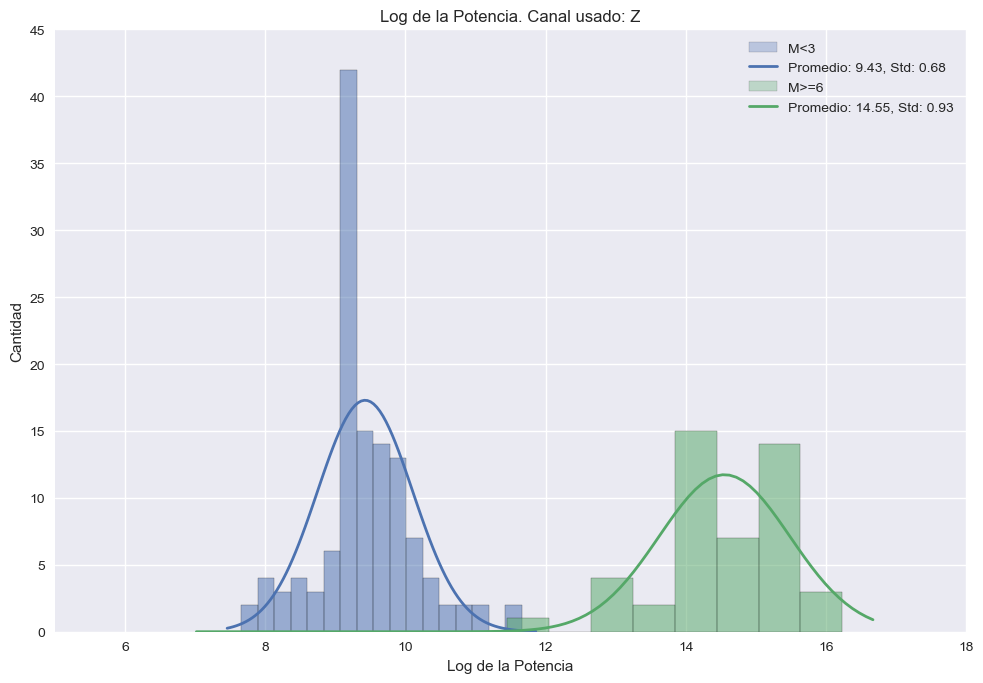

(array([ 9.42579132, 14.55166135]),
 array([0.67881278, 0.93368495]),
 array([0.46078679, 0.87176759]),
 array([0.73099415, 0.26900585]),
 array([[8.80990952e-03, 1.06290060e-02, 1.27688101e-02, 1.52737183e-02,
         1.81918011e-02, 2.15746220e-02, 2.54769401e-02, 2.99562819e-02,
         3.50723709e-02, 4.08864039e-02, 4.74601687e-02, 5.48549993e-02,
         6.31305719e-02, 7.23435483e-02, 8.25460816e-02, 9.37842030e-02,
         1.06096118e-01, 1.19510447e-01, 1.34044445e-01, 1.49702255e-01,
         1.66473243e-01, 1.84330461e-01, 2.03229314e-01, 2.23106472e-01,
         2.43879086e-01, 2.65444371e-01, 2.87679594e-01, 3.10442496e-01,
         3.33572200e-01, 3.56890597e-01, 3.80204222e-01, 4.03306608e-01,
         4.25981084e-01, 4.48003971e-01, 4.69148126e-01, 4.89186747e-01,
         5.07897356e-01, 5.25065876e-01, 5.40490681e-01, 5.53986524e-01,
         5.65388230e-01, 5.74554062e-01, 5.81368649e-01, 5.85745406e-01,
         5.87628360e-01, 5.86993344e-01, 5.83848515e-01, 5.

In [23]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12_Z, power_events_mag69_Z], station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[5,18] ,y_lim=45)

In [ ]:
event_type = ['M<4','M>=6']
plot_power([power_under_4_Z, power_events_mag69_Z], station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=60)

In [ ]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=50)


## 4.2. Canal E

In [24]:
power_all_mags_E = [power_events_mag12_E, power_events_mag3_E, power_events_mag4_E, power_events_mag5_E, power_events_mag69_E]

power_over_3_E = list(itertools.chain(power_events_mag3_E, power_events_mag4_E, power_events_mag5_E, power_events_mag69_E))

power_over_4_E = list(itertools.chain(power_events_mag4_E, power_events_mag5_E, power_events_mag69_E))
power_under_4_E = list(itertools.chain(power_events_mag12_E, power_events_mag3_E))

power_over_5_E = list(itertools.chain(power_events_mag5_E, power_events_mag69_E))
power_under_5_E = list(itertools.chain(power_under_4_E, power_events_mag4_E))

power_under_6_E = list(itertools.chain(power_under_5_E, power_events_mag5_E))

power_sep_3_E = [power_events_mag12_E, power_over_3_E]
power_sep_4_E = [power_under_4_E, power_over_4_E]
power_sep_5_E = [power_under_5_E, power_over_5_E]
power_sep_6_E = [power_under_6_E, power_events_mag69_E]


In [ ]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3_E, station = '', channel = 'E' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4_E, station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5_E, station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6_E, station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=70)

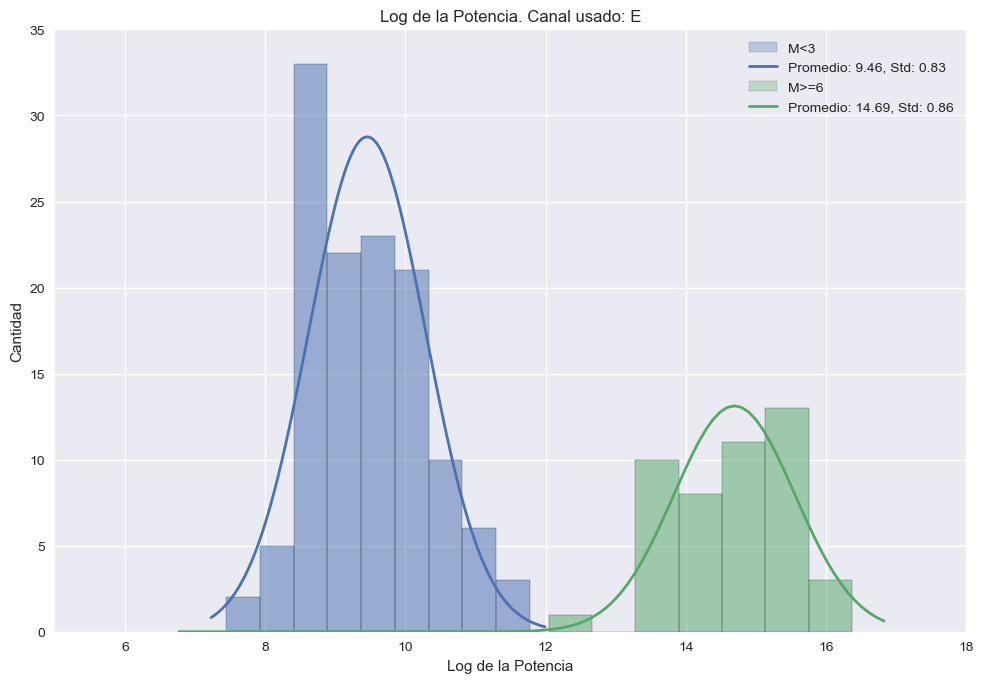

(array([ 9.45557423, 14.69354166]),
 array([0.83442795, 0.86379109]),
 array([0.69627   , 0.74613504]),
 array([0.73099415, 0.26900585]),
 array([[1.35847060e-02, 1.58188192e-02, 1.83591753e-02, 2.12367259e-02,
         2.44837109e-02, 2.81333994e-02, 3.22197724e-02, 3.67771451e-02,
         4.18397273e-02, 4.74411235e-02, 5.36137733e-02, 6.03883369e-02,
         6.77930312e-02, 7.58529236e-02, 8.45891934e-02, 9.40183728e-02,
         1.04151581e-01, 1.14993764e-01, 1.26542963e-01, 1.38789623e-01,
         1.51715965e-01, 1.65295434e-01, 1.79492257e-01, 1.94261111e-01,
         2.09546931e-01, 2.25284873e-01, 2.41400432e-01, 2.57809754e-01,
         2.74420109e-01, 2.91130569e-01, 3.07832857e-01, 3.24412385e-01,
         3.40749451e-01, 3.56720603e-01, 3.72200120e-01, 3.87061622e-01,
         4.01179749e-01, 4.14431904e-01, 4.26700005e-01, 4.37872230e-01,
         4.47844706e-01, 4.56523118e-01, 4.63824188e-01, 4.69677006e-01,
         4.74024176e-01, 4.76822756e-01, 4.78044959e-01, 4.

In [27]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12_E, power_events_mag69_E], station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[5,18] ,y_lim=35)

In [ ]:
event_type = ['M<4','M>=6']
plot_power([power_under_4_E, power_events_mag69_E], station = '', channel = 'E' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=60)

In [ ]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags_E, station = '', channel = 'E' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=30)


## 4.3. Canal N

In [28]:
power_all_mags_N = [power_events_mag12_N, power_events_mag3_N, power_events_mag4_N, power_events_mag5_N, power_events_mag69_N]

power_over_3_N = list(itertools.chain(power_events_mag3_N, power_events_mag4_N, power_events_mag5_N, power_events_mag69_N))

power_over_4_N = list(itertools.chain(power_events_mag4_N, power_events_mag5_N, power_events_mag69_N))
power_under_4_N = list(itertools.chain(power_events_mag12_N, power_events_mag3_N))

power_over_5_N = list(itertools.chain(power_events_mag5_N, power_events_mag69_N))
power_under_5_N = list(itertools.chain(power_under_4_N, power_events_mag4_N))

power_under_6_N = list(itertools.chain(power_under_5_N, power_events_mag5_N))

power_sep_3_N = [power_events_mag12_N, power_over_3_N]
power_sep_4_N = [power_under_4_N, power_over_4_N]
power_sep_5_N = [power_under_5_N, power_over_5_N]
power_sep_6_N = [power_under_6_N, power_events_mag69_N]


In [ ]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3_N, station = '', channel = 'N' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4_N, station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5_N, station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6_N, station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=70)

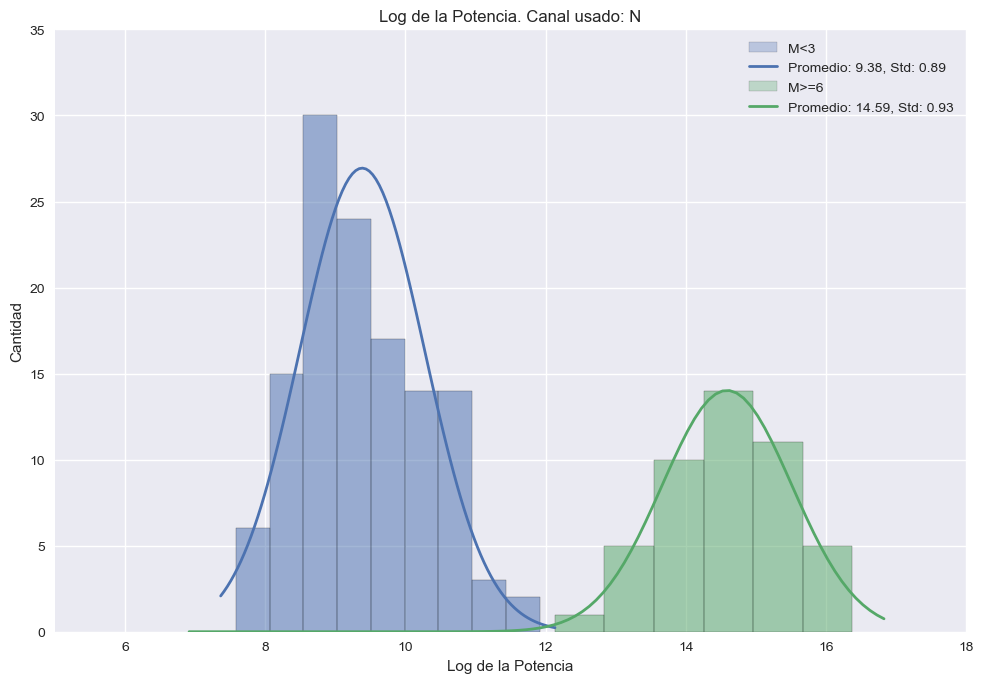

(array([ 9.38428003, 14.58756806]),
 array([0.89154737, 0.92566531]),
 array([0.79485672, 0.85685627]),
 array([0.73099415, 0.26900585]),
 array([[3.45358575e-02, 3.89709733e-02, 4.38474952e-02, 4.91904566e-02,
         5.50236563e-02, 6.13692147e-02, 6.82471018e-02, 7.56746444e-02,
         8.36660166e-02, 9.22317234e-02, 1.01378085e-01, 1.11106731e-01,
         1.21414117e-01, 1.32291069e-01, 1.43722379e-01, 1.55686443e-01,
         1.68154975e-01, 1.81092797e-01, 1.94457706e-01, 2.08200452e-01,
         2.22264808e-01, 2.36587758e-01, 2.51099798e-01, 2.65725347e-01,
         2.80383293e-01, 2.94987633e-01, 3.09448237e-01, 3.23671712e-01,
         3.37562353e-01, 3.51023177e-01, 3.63957027e-01, 3.76267712e-01,
         3.87861188e-01, 3.98646745e-01, 4.08538180e-01, 4.17454940e-01,
         4.25323214e-01, 4.32076949e-01, 4.37658770e-01, 4.42020796e-01,
         4.45125317e-01, 4.46945344e-01, 4.47464996e-01, 4.46679730e-01,
         4.44596408e-01, 4.41233200e-01, 4.36619315e-01, 4.

In [42]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12_N, power_events_mag69_N], station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[5,18] ,y_lim=35)

In [ ]:
event_type = ['M<4','M>=6']
plot_power([power_under_4_N, power_events_mag69_N], station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[5,18] ,y_lim=60)

In [ ]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags_N, station = '', channel = 'N' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=30)


# 5. Analisis de los eventos M>6

## 5.1. Aplicamos sta/lta a los eventos M>6

In [43]:
# calculate sta/lta algo for the whole trace_mag69_v2_Z list
trace_mag69_v2_Z = {k: v.trim(starttime=v.stats.starttime + 1, pad=True, fill_value=0) for k, v in trace_mag69_v2_Z.items()} # este código saca el primer segundo, esto ya que en el primer segundo hay como un pick extraño
trace_mag69_v2_Z_stream = [Stream(traces = trace) for trace in trace_mag69_v2_Z.values()]
sta_lta_mag6 = [p_picking_each(trace, ventana_10s = 10, ventana_30s = 30, nsta = 3, nlta = 13, thr_on = 4.2, thr_off = 1) for trace in trace_mag69_v2_Z_stream]

ic(len(trace_mag69_v2_Z_stream))
ic(len(sta_lta_mag6))


ic| len(trace_mag69_v2_Z_stream): 46
ic| len(sta_lta_mag6): 46


46

In [44]:
def analize_sta_lta(sta_lta: list, trace: dict, duration: float, off: bool = False):
    tr = list(trace.values())[0]
    key = list(trace.keys())[0]
    if sta_lta is not None:
        fig, ax = plt.subplots(figsize=(7, 3))
        ax.plot(tr.times(), tr.data, 'k')
        ax.set_title(f'Canal: {tr.stats.channel}. EventId: {key} ')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        #ax.set_xlim(0, 100)
        # add a vertical line where the cft array surpasses the threshold of 4.3
        ax.axvline(sta_lta - tr.stats.starttime ,  color='r', linestyle='--', label='ON')
        if off:
            ax.axvline(sta_lta - tr.stats.starttime + duration ,  color='b', linestyle='--', label='OFF')
        ax.legend()
        #plt.show()

    

## 5.2. Se guardan como imagenes los eventos en la carpeta definida

In [34]:
# Obtener las ID y data de los eventos
output_folder = os.path.join('BD paper', 'catalogos', 'plots_señales_6')
os.makedirs(output_folder, exist_ok=True)
keys = list(trace_mag69_v2_Z.keys())
values = list(trace_mag69_v2_Z.values())
plt.rcParams['figure.constrained_layout.use'] = True

sta_lta_mag6_clean = {}
count= 0
for i in range(len(sta_lta_mag6)):
    key = keys[i]
    value = values[i]
    if sta_lta_mag6[i]:
        count += 1
        sta_lta_mag6_clean[key] = sta_lta_mag6[i][0]
        # Extraer los datos y el tiempo del objeto de ObsPy
        data = value.data
        time = value.times('matplotlib')
        
        # Crear una figura y un eje con matplotlib
        fig, ax = plt.subplots(figsize=(15, 5))  # Cambiar el tamaño de la figura
        
        # Trazar los datos
        ax.plot_date(time, data, '-')
        
        # Ajustar los ejes
        ax.autoscale_view()
        fig.autofmt_xdate()
        #Agregar titulo
        ax.set_title(f'Canal: {value.stats.channel}. EventId: {key} ')

        # Agregar etiquetas a los ejes
        ax.set_xlabel('Tiempo')
        ax.set_ylabel('Amplitud')
        
        # Configurar las marcas del eje x para que aparezcan cada 30 segundos
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        
        # Guardar la figura
        plot_path = os.path.join(output_folder, f'evento_{key}.png')
        plt.savefig(plot_path)
        plt.close()
        



#### Solo un ejemplo de evento

ic| sta_lta_mag6[idx]: []
ic| tr_mag69_list[idx]: <obspy.core.trace.Trace object at 0x000001CFBCD6D420>


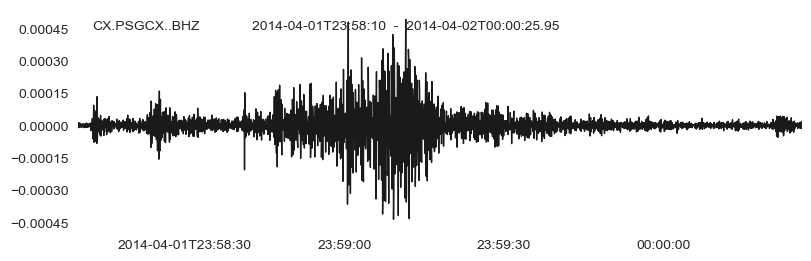

In [45]:
idx = 9
tr_mag69_list = list(trace_mag69_v2_Z.values())
ic(sta_lta_mag6[idx])
ic(tr_mag69_list[idx])
tr_mag69_list[idx].plot()
plt.show()

Los tiempos de incio quedaron guardados en el diccionario sta_lta_mag6_clean y en la lista. Esto en los casos donde las señales que son triggereadas por sta/lta. Hay 2 eventos que no fueron triggereados,


## 5.3. Cálculo del fin del evento.
Esto se hace considerando cuando la energía baja del 3% de su peak por frames según estipulado en el paper 

In [46]:
#ic(len(sta_lta_mag6_clean))
ic(len(sta_lta_mag6))
ic(len(trace_mag69_v2_Z))
ic(len(trace_mag69_v2_Z_stream))

ic| len(sta_lta_mag6): 46
ic| len(trace_mag69_v2_Z): 46
ic| len(trace_mag69_v2_Z_stream): 46


46

In [47]:
# Se calcula el punto donde cada traza tendría su finalización del evento
end_event = [endpoint_event(value.data, thr_energy = 0.97)[1] for value in values]
peak_enegy = [endpoint_event(value.data)[0] for value in values]

sliced_trs = []
duration = []
j = 0
k = []
for i in range(len(trace_mag69_v2_Z_stream)):
    if sta_lta_mag6[i]:
        sliced_trs.append(trace_mag69_v2_Z_stream[i].slice(starttime = sta_lta_mag6[i][0], endtime=sta_lta_mag6[i][0] + end_event[i]/40))
        duration.append(sliced_trs[j][0].stats.endtime - sliced_trs[j][0].stats.starttime)
        j += 1
    else:
        k.append(i)



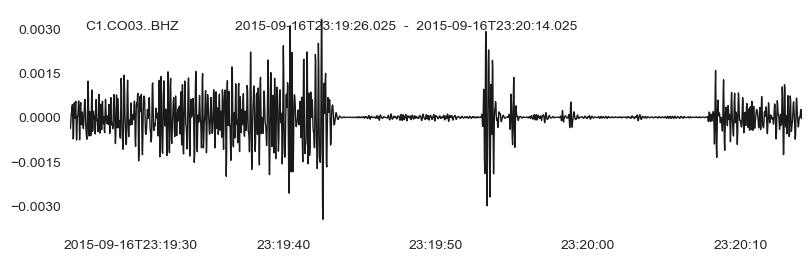

Start time: 2015-09-16T23:19:26.025000Z
End time: 2015-09-16T23:20:14.025000Z


In [48]:
# Se grafican las trazas cortadas
sliced_trs[12].plot()
print('Start time:', sliced_trs[12][0].stats.starttime)
print('End time:', sliced_trs[12][0].stats.endtime)

In [ ]:
## 

## 5.4. Se plotean todos los eventos con sus tiempos de inicio y fin.
Esta celda se debe correr, pero si no se quieren los gráficos, basta comentar la linea que tiene a la función analize_sta_lta

In [ ]:
# Obtener las ID y data de los eventos
keys = list(trace_mag69_v2_Z.keys())
values = list(trace_mag69_v2_Z.values())

sta_lta_mag6_clean = {}
count= 0
j = 0
for i in range(len(sta_lta_mag6)):
    key = keys[i]
    value = values[i]
    if sta_lta_mag6[i]:
        count += 1
        sta_lta_mag6_clean[key] = sta_lta_mag6[i][0]
        analize_sta_lta(sta_lta_mag6[i][0], {key: value}, duration[j], off=True)
        j += 1

# 4597528
# 5159025
        


### Decaimiento del 3% del frame con la energía máxima 

In [52]:
dur = np.array(duration)
ic(np.mean(dur).round(2))
# calcula la desviacion estandar de dur
ic(np.std(dur).round(2))

ic| np.mean(dur).round(2): 37.36
ic| np.std(dur).round(2): 15.28


15.28

### Creación del excel

In [53]:
path_to_duration = os.path.join('BD paper', 'catalogos', 'duracion_eventos.xlsx')
# take the column "Duracion(s)" and calculate the mean and std
df_to_change = pd.read_excel(path_to_duration)

# Calculate the mean and standard deviation
mean_dur = np.mean(df_to_change['Duracion(s)']).round(2)
std_dur = round(np.std(df_to_change['Duracion(s)']),2)
max_dur = np.max(df_to_change['Duracion(s)'])
min_dur = np.min(df_to_change['Duracion(s)'])

# Add a new column 'Promedio' and 'Std' and set the first cell to the calculated values
df_to_change.at[0, 'Promedio'] = mean_dur
df_to_change.at[0, 'Sismo más largo'] = max_dur
df_to_change.at[0, 'Sismo más corto'] = min_dur
df_to_change.at[0, 'Std'] = std_dur

# Save the modified DataFrame back to an Excel file
df_to_change.to_excel(path_to_duration , index=False)


# 6. Clasificación 

In [54]:
classes = ['M<3', 'M>=6']

power_all_mags_Z = [power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z]


#power_to_test_Z = [power_events_mag12_Z, power_events_mag5_Z ,power_events_mag69_Z]
power_to_test_Z = [power_events_mag12_Z,power_events_mag69_Z]
power_last_frame_Z = [arr[-1] for tup in power_to_test_Z  for arr in tup]

X_z = np.array(power_last_frame_Z).reshape(-1,1)
X_z = np.log10(X_z)

y_z = np.concatenate([np.zeros(len(power_to_test_Z[0])),
                         np.ones(len(power_to_test_Z[1]))])

#power_to_test_E = [power_events_mag12_E, power_events_mag5_E ,power_events_mag69_E]
power_to_test_E = [power_events_mag12_E,power_events_mag69_E]
power_last_frame_E = [arr[-1] for tup in power_to_test_E  for arr in tup]

X_e = np.array(power_last_frame_E).reshape(-1,1)
X_e = np.log10(X_e)

# y_e = np.concatenate([np.zeros(len(power_to_test_E[0])),
#                          np.ones(len(power_to_test_E[1])),
#                          np.ones(len(power_to_test_E[2]))])

#power_to_test_N = [power_events_mag12_N, power_events_mag5_N ,power_events_mag69_N]
power_to_test_N = [power_events_mag12_N,power_events_mag69_N]
power_last_frame_N = [arr[-1] for tup in power_to_test_N  for arr in tup]

X_n = np.array(power_last_frame_N).reshape(-1,1)
X_n = np.log10(X_n)

# y_n = np.concatenate([np.zeros(len(power_to_test_N[0])),
#                          np.ones(len(power_to_test_N[1])),
#                          np.ones(len(power_to_test_N[2]))])


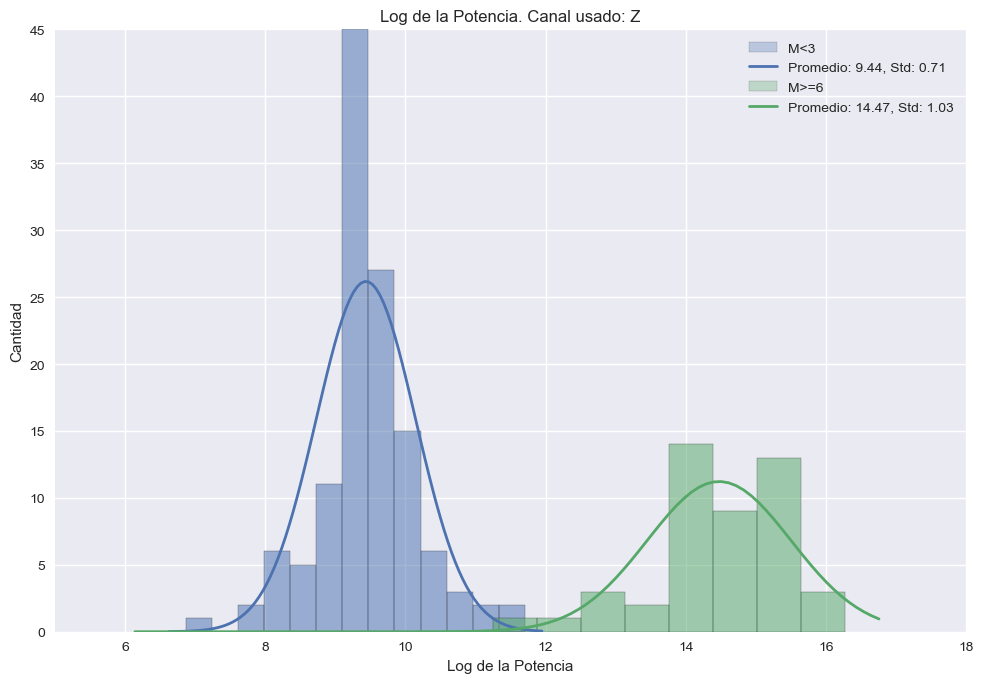

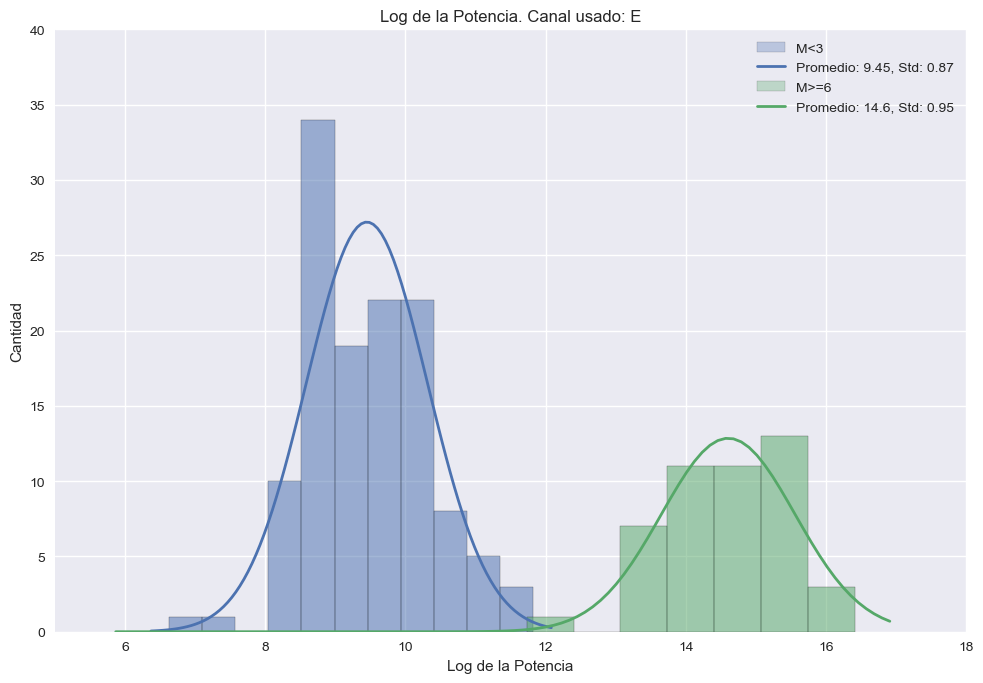

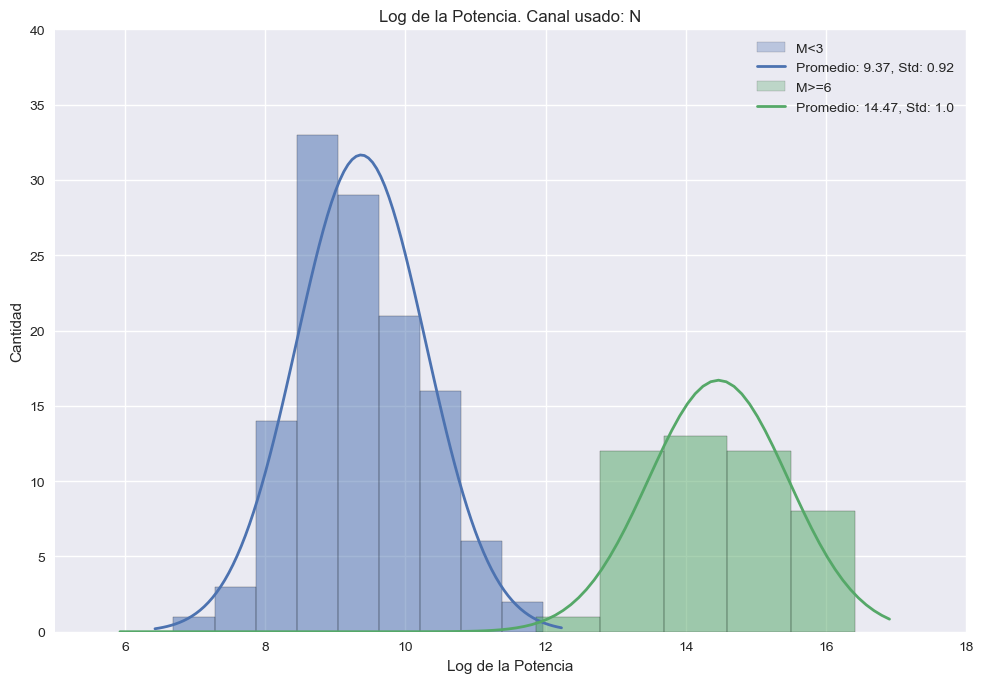

In [79]:
x_lim = [5, 18]
n_frames = 9
means_z, std_z, covar_z, weights_z, pdf = plot_power([power_events_mag12_Z, power_events_mag69_Z], station = '', channel = 'Z',
                                                       n_frames=n_frames, use_log=True, height = 10, width = 7, event_type=classes, x_lim=x_lim ,y_lim=45)

means_e, std_e, covar_e, weights_e, pdf = plot_power([power_events_mag12_E, power_events_mag69_E], station = '', channel = 'E',
                                                         n_frames=n_frames, use_log=True, height = 10, width = 7, event_type=classes, x_lim=x_lim ,y_lim=40)

means_n, std_n, covar_n, weights_n, pdf = plot_power([power_events_mag12_N, power_events_mag69_N], station = '', channel = 'N',  
                                                            n_frames=n_frames, use_log=True, height = 10, width = 7, event_type=classes, x_lim=x_lim ,y_lim=40)

In [80]:
def max_likelihood_classifier(x, class_1_mean, class_1_var, class_2_mean, class_2_var):
    """
    Clasificador de Máxima Verosimilitud Simple.

    Parameters:
    - x: Valor a clasificar.
    - class_1_mean: Media de la primera clase.
    - class_1_var: Varianza de la primera clase.
    - class_2_mean: Media de la segunda clase.
    - class_2_var: Varianza de la segunda clase.

    Returns:
    - Clase asignada (1 o 2).
    """
    prob_class_1 = 1 / np.sqrt(2 * np.pi * class_1_var) * np.exp(-(x - class_1_mean)**2 / (2 * class_1_var))
    prob_class_2 = 1 / np.sqrt(2 * np.pi * class_2_var) * np.exp(-(x - class_2_mean)**2 / (2 * class_2_var))

    if prob_class_1 > prob_class_2:
        return 0  # Clase 1
    else:
        return 1  # Clase 2

predicted_class_z = []
for x in X_z:
    predicted_class_z.append(max_likelihood_classifier(x, means_z[0], covar_z[0], means_z[1], covar_z[1]))

predicted_class_z = np.array(predicted_class_z)
cm_z = confusion_matrix(y_z, predicted_class_z)

predicted_class_e = []
for x in X_e:
    predicted_class_e.append(max_likelihood_classifier(x, means_e[0], covar_e[0], means_e[1], covar_e[1]))

cm_e = confusion_matrix(y_z, predicted_class_e)

predicted_class_n = []
for x in X_n:
    predicted_class_n.append(max_likelihood_classifier(x, means_n[0], covar_n[0], means_n[1], covar_n[1]))

cm_n = confusion_matrix(y_z, predicted_class_n)


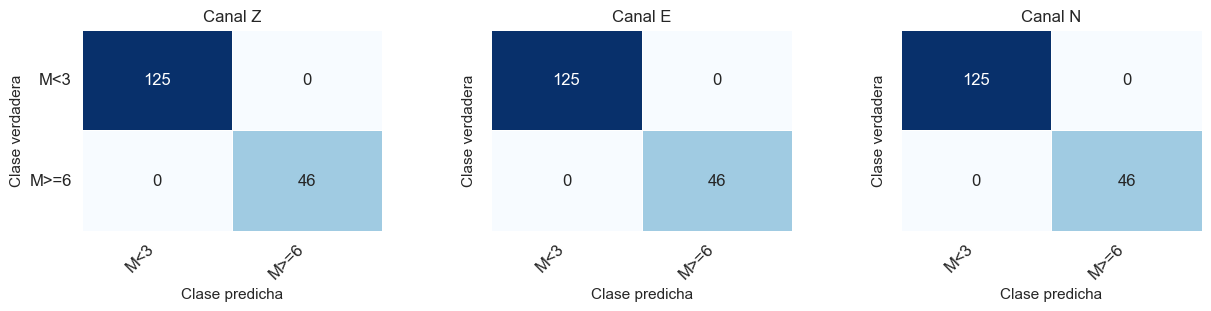

In [81]:
# Crear un mapa de calor de la matriz de confusión para el canal Z, E y N
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=False, gridspec_kw={'wspace': 0.2})

# Canal Z
heatmap_z = sns.heatmap(cm_z, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax[0])
heatmap_z.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_z.set_yticklabels(classes, rotation=0, fontsize=12)
ax[0].set_title('Canal Z')
ax[0].set_xlabel('Clase predicha')
ax[0].set_ylabel('Clase verdadera')

# Canal E
heatmap_e = sns.heatmap(cm_e, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax[1])
heatmap_e.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_e.set_yticklabels([])  # Eliminar etiquetas del eje y
ax[1].set_title('Canal E')
ax[1].set_xlabel('Clase predicha')
ax[1].set_ylabel('Clase verdadera')

# Canal N con barra de colores
heatmap_n = sns.heatmap(cm_n, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax[2])
heatmap_n.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_n.set_yticklabels([])  # Eliminar etiquetas del eje y
ax[2].set_title('Canal N')
ax[2].set_xlabel('Clase predicha')
ax[2].set_ylabel('Clase verdadera')

#fig.colorbar(ax[1].collections[0], cax=ax[3])

# Ajustar el diseño para evitar superposiciones
plt.subplots_adjust(wspace=0.5)
plt.show()

In [64]:
# Primero, vamos a combinar los datos de los canales Z y E en un solo array
X_ze = np.concatenate((X_z, X_e), axis=1)

# Ahora, vamos a calcular las medias y las matrices de covarianza para cada clase
class_1_data = X_ze[y_z == 0]
class_2_data = X_ze[y_z == 1]

class_1_mean = np.mean(class_1_data, axis=0)
class_2_mean = np.mean(class_2_data, axis=0)

class_1_covar = np.cov(class_1_data, rowvar=False)
class_2_covar = np.cov(class_2_data, rowvar=False)

means_ze = [class_1_mean, class_2_mean]
covar_ze = [class_1_covar, class_2_covar]

# Ahora, vamos a definir un clasificador de máxima verosimilitud para dos dimensiones
from scipy.stats import multivariate_normal
def max_likelihood_classifier_2d(x, class_1_mean, class_1_covar, class_2_mean, class_2_covar):
    """
    Clasificador de Máxima Verosimilitud para dos dimensiones.

    Parameters:
    - x: Valor a clasificar.
    - class_1_mean: Media de la primera clase.
    - class_1_covar: Matriz de covarianza de la primera clase.
    - class_2_mean: Media de la segunda clase.
    - class_2_covar: Matriz de covarianza de la segunda clase.

    Returns:
    - Clase asignada (1 o 2).
    """
    prob_class_1 = multivariate_normal.pdf(x, mean=class_1_mean, cov=class_1_covar)
    prob_class_2 = multivariate_normal.pdf(x, mean=class_2_mean, cov=class_2_covar)

    if prob_class_1 > prob_class_2:
        return 0  # Clase 1
    else:
        return 1  # Clase 2

# Ahora, vamos a clasificar nuestros datos
predicted_class_ze = []
for x in X_ze:
    predicted_class_ze.append(max_likelihood_classifier_2d(x, means_ze[0], covar_ze[0], means_ze[1], covar_ze[1]))

cm_ze = confusion_matrix(y_z, predicted_class_ze)

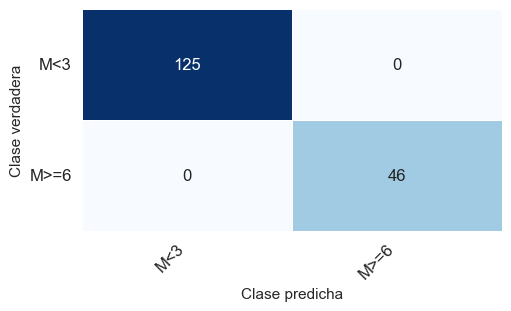

In [65]:
#plot matriz de confusion cm_ze 
fig, ax = plt.subplots(figsize=(5, 3))
heatmap_ze = sns.heatmap(cm_ze, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
heatmap_ze.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_ze.set_yticklabels(classes, rotation=0, fontsize=12)
# ax.set_title('Canales Z y E')
ax.set_xlabel('Clase predicha')
ax.set_ylabel('Clase verdadera')
plt.show()

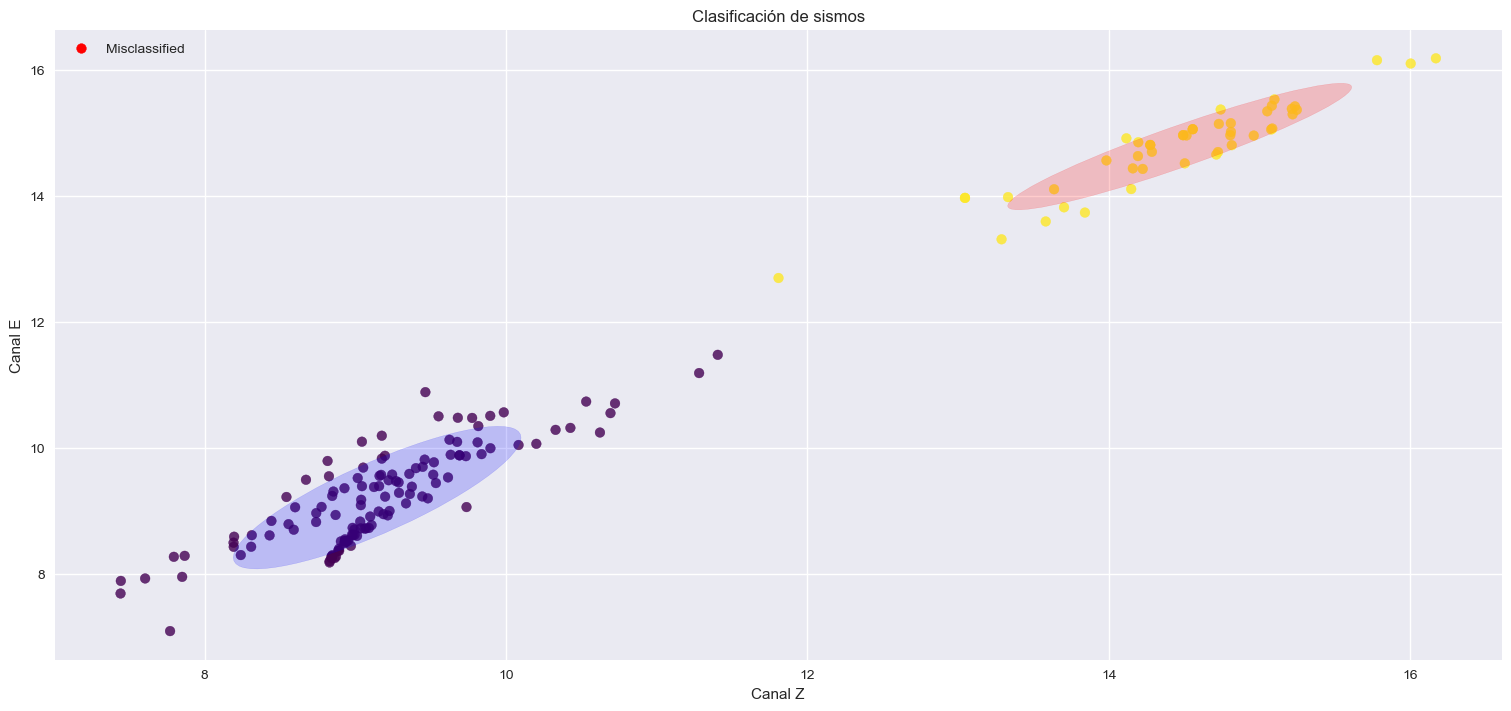

In [66]:
#import Ellipse
from matplotlib.patches import Ellipse
# Creamos la figura
fig, ax = plt.subplots(figsize=(15, 7))

# Dibujamos los datos
scatter = ax.scatter(X_ze[:, 0], X_ze[:, 1], c=y_z, cmap='viridis', alpha=0.8)
# Calculamos las matrices de confusión
cm_ze = confusion_matrix(y_z, predicted_class_ze)

# Dibujamos los puntos mal clasificados en rojo
misclassified = (y_z != predicted_class_ze)
ax.scatter(X_ze[misclassified, 0], X_ze[misclassified, 1], c='red', label='Misclassified')

# Calculamos las elipses para cada clase
for i, color in enumerate(['blue', 'red']):
    # Calculamos los vectores y valores propios de la matriz de covarianza
    v, w = np.linalg.eigh(covar_ze[i])
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])

    # Creamos la elipse
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = Ellipse(means_ze[i], v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.2)
    ax.add_artist(ell)

# Añadimos las etiquetas
plt.title('Clasificación de sismos')
plt.xlabel('Canal Z')
plt.ylabel('Canal E')
plt.legend()

# Mostramos el gráfico
plt.show()


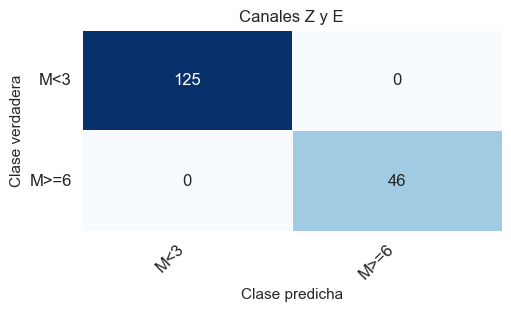

In [67]:
#plot confussion matrix cm_ze 
fig, ax = plt.subplots(figsize=(5, 3))
heatmap_ze = sns.heatmap(cm_ze, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
heatmap_ze.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_ze.set_yticklabels(classes, rotation=0, fontsize=12)
ax.set_title('Canales Z y E')
ax.set_xlabel('Clase predicha')
ax.set_ylabel('Clase verdadera')
plt.show()


# PARA 3D

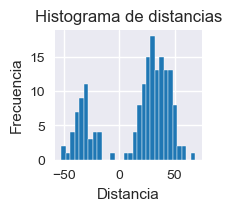

In [69]:
# Primero, vamos a combinar los datos de los canales Z, E y N en un solo array
X_zen = np.concatenate((X_z, X_e, X_n), axis=1)

# Ahora, vamos a calcular las medias y las matrices de covarianza para cada clase
class_1_data = X_zen[y_z == 0]
class_2_data = X_zen[y_z == 1]

class_1_mean = np.mean(class_1_data, axis=0)
class_2_mean = np.mean(class_2_data, axis=0)

class_1_covar = np.cov(class_1_data, rowvar=False)
class_2_covar = np.cov(class_2_data, rowvar=False)

means_zen = [class_1_mean, class_2_mean]
covar_zen = [class_1_covar, class_2_covar]

#matriz de confusion
cm_zen = confusion_matrix(y_z, predicted_class_zen)

# Ahora, vamos a definir un clasificador de máxima verosimilitud para tres dimensiones
def max_likelihood_classifier_3d(x, class_1_mean, class_1_covar, class_2_mean, class_2_covar):
    """
    Clasificador de Máxima Verosimilitud para tres dimensiones.

    Entradas:
    - x: Valor a clasificar.
    - class_1_mean: Media de la primera clase.
    - class_1_covar: Matriz de covarianza de la primera clase.
    - class_2_mean: Media de la segunda clase.
    - class_2_covar: Matriz de covarianza de la segunda clase.

    Salida:
    - Clase asignada (0 o 1).
    """
    log_prob_class_1 = multivariate_normal.logpdf(x, mean=class_1_mean, cov=class_1_covar)
    log_prob_class_2 = multivariate_normal.logpdf(x, mean=class_2_mean, cov=class_2_covar)

    # Calculamos la "distancia" como la diferencia de log-verosimilitudes
    distance = log_prob_class_1 - log_prob_class_2

    if distance > 0:
        return 0, distance  # Clase 1
    else:
        return 1, distance  # Clase 2

# Ahora, vamos a clasificar nuestros datos
predicted_class_zen = []
distances = []
for x in X_zen:
    predicted_class, distance = max_likelihood_classifier_3d(x, means_zen[0], covar_zen[0], means_zen[1], covar_zen[1])
    predicted_class_zen.append(predicted_class)
    if predicted_class == 0:
        distances.append(distance)
    distances.append(distance)

plt.hist(distances, bins=30)
plt.title('Histograma de distancias')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.show()




In [ ]:
# Y finalmente, vamos a visualizar los resultados
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(17, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_zen[:, 0], X_zen[:, 1], X_zen[:, 2], c=predicted_class_zen, cmap='viridis')
ax.set_title('Clasificación de sismos')
ax.set_xlabel('Canal Z')
ax.set_ylabel('Canal E')
ax.set_zlabel('Canal N')
plt.show()

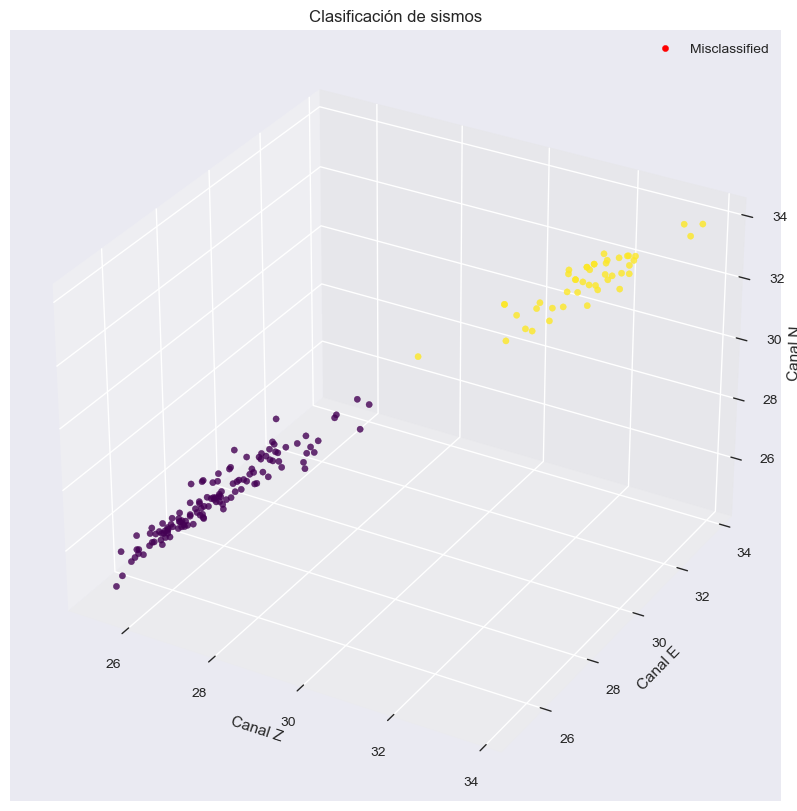

In [103]:
# Creamos la figura
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Dibujamos los datos
scatter = ax.scatter(X_zen[:, 0], X_zen[:, 1], X_zen[:, 2], c=y_z, cmap='viridis', alpha=0.8)

# Dibujamos los puntos mal clasificados en rojo
misclassified = (y_z != predicted_class_zen)
ax.scatter(X_zen[misclassified, 0], X_zen[misclassified, 1], X_zen[misclassified, 2], c='red', label='Misclassified')

# Añadimos las etiquetas
ax.set_title('Clasificación de sismos')
ax.set_xlabel('Canal Z')
ax.set_ylabel('Canal E')
ax.set_zlabel('Canal N')
plt.legend()

# Mostramos el gráfico
plt.show()


TypeError: return arrays must be of ArrayType

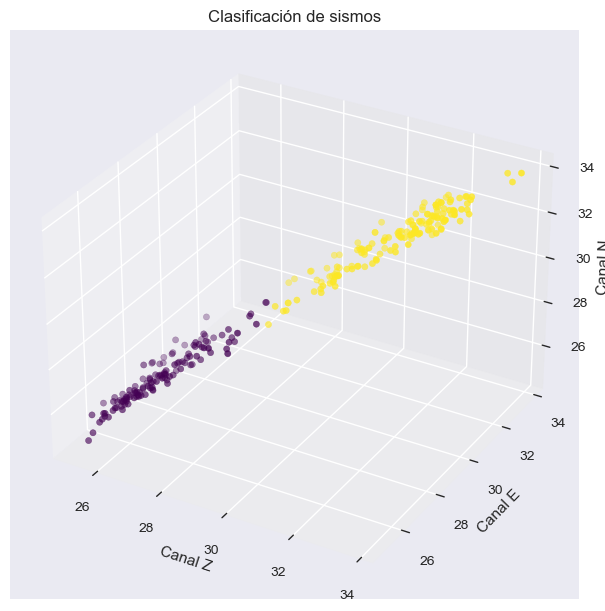

In [74]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Función para dibujar un elipsoide
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plota un elipsoide de confianza basado en una matriz de covarianza dada y una posición media.
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Ancho y altura son escalas de sigma principal
    width, height, z_height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

# Dibujamos los datos con los elipsoides
fig = plt.figure(figsize=(17, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_zen[:, 0], X_zen[:, 1], X_zen[:, 2], c=predicted_class_zen, cmap='viridis')
ax.set_title('Clasificación de sismos')
ax.set_xlabel('Canal Z')
ax.set_ylabel('Canal E')
ax.set_zlabel('Canal N')

# Dibujamos los elipsoides para cada clase
plot_cov_ellipse(covar_zen[0], means_zen[0], ax=ax, alpha=0.2, color='blue')
plot_cov_ellipse(covar_zen[1], means_zen[1], ax=ax, alpha=0.2, color='red')

# Identificamos los puntos mal clasificados
predicted_class_zen = np.array(predicted_class_zen)
misclassified = predicted_class_zen != y_z
ax.scatter(X_zen[misclassified, 0], X_zen[misclassified, 1], X_zen[misclassified, 2], c='red', marker='x')

plt.show()



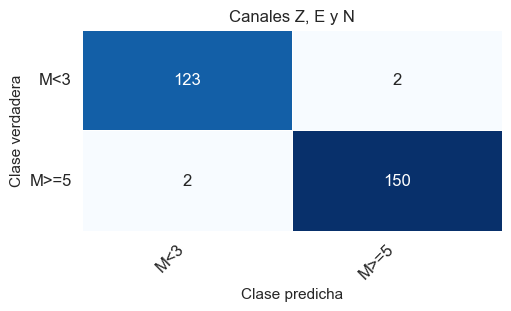

In [64]:
# plot confussion matrix cm_zen
fig, ax = plt.subplots(figsize=(5, 3))
heatmap_zen = sns.heatmap(cm_zen, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
heatmap_zen.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_zen.set_yticklabels(classes, rotation=0, fontsize=12)
ax.set_title('Canales Z, E y N')
ax.set_xlabel('Clase predicha')
ax.set_ylabel('Clase verdadera')
plt.show()



# 6. Gaussian Mixtures Models

In [33]:
classes = ['M<3', 'M>=5']

power_all_mags_Z = [power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z]


power_to_test_Z = [power_events_mag12_Z, power_events_mag5_Z ,power_events_mag69_Z]
power_last_frame_Z = [arr[-1] for tup in power_to_test_Z  for arr in tup]

X_z = np.array(power_last_frame_Z).reshape(-1,1)
X_z = np.log10(X_z)

y_z = np.concatenate([np.zeros(len(power_to_test_Z[0])),
                         np.ones(len(power_to_test_Z[1])),
                         np.ones(len(power_to_test_Z[2]))])

power_to_test_E = [power_events_mag12_E, power_events_mag5_E ,power_events_mag69_E]
power_last_frame_E = [arr[-1] for tup in power_to_test_E  for arr in tup]

X_e = np.array(power_last_frame_E).reshape(-1,1)
X_e = np.log10(X_e)

y_e = np.concatenate([np.zeros(len(power_to_test_E[0])),
                         np.ones(len(power_to_test_E[1])),
                         np.ones(len(power_to_test_E[2]))])

power_to_test_N = [power_events_mag12_N, power_events_mag5_N ,power_events_mag69_N]
power_last_frame_N = [arr[-1] for tup in power_to_test_N  for arr in tup]

X_n = np.array(power_last_frame_N).reshape(-1,1)
X_n = np.log10(X_n)

y_n = np.concatenate([np.zeros(len(power_to_test_N[0])),
                         np.ones(len(power_to_test_N[1])),
                         np.ones(len(power_to_test_N[2]))])


In [34]:
rng = np.random.RandomState(42)

# Primero para el canal Z
X_train_Z, X_test_Z, y_train_Z, y_test_Z = train_test_split(X_z, y_z, test_size=0.3, random_state=rng)
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X_e, y_e, test_size=0.3, random_state=rng)
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(X_n, y_n, test_size=0.3, random_state=rng)

# Crear un modelo GMM para cada canal
gmm_z = GaussianMixture(n_components=2, random_state=rng)
gmm_e = GaussianMixture(n_components=2, random_state=rng)
gmm_n = GaussianMixture(n_components=2, random_state=rng)

# Entrenar los modelos
gmm_z.fit(X_train_Z)
gmm_e.fit(X_train_E)
gmm_n.fit(X_train_N)

# Predecir las etiquetas para los datos
labels_z = gmm_z.predict(X_test_Z)
labels_e = gmm_e.predict(X_test_E)
labels_n = gmm_n.predict(X_test_N)

# Ordenar las etiquetas según la clase con más elementos
if np.sum(labels_z == 0) > np.sum(labels_z == 1):
    labels_z = 1 - labels_z

if np.sum(labels_e == 0) > np.sum(labels_e == 1):
    labels_e = 1 - labels_e

if np.sum(labels_n == 0) > np.sum(labels_n == 1):
    labels_n = 1 - labels_n

# Calcular la matriz de confusión
cm_Z = confusion_matrix(y_test_Z, labels_z)
cm_E = confusion_matrix(y_test_E, labels_e)
cm_N = confusion_matrix(y_test_N, labels_n)



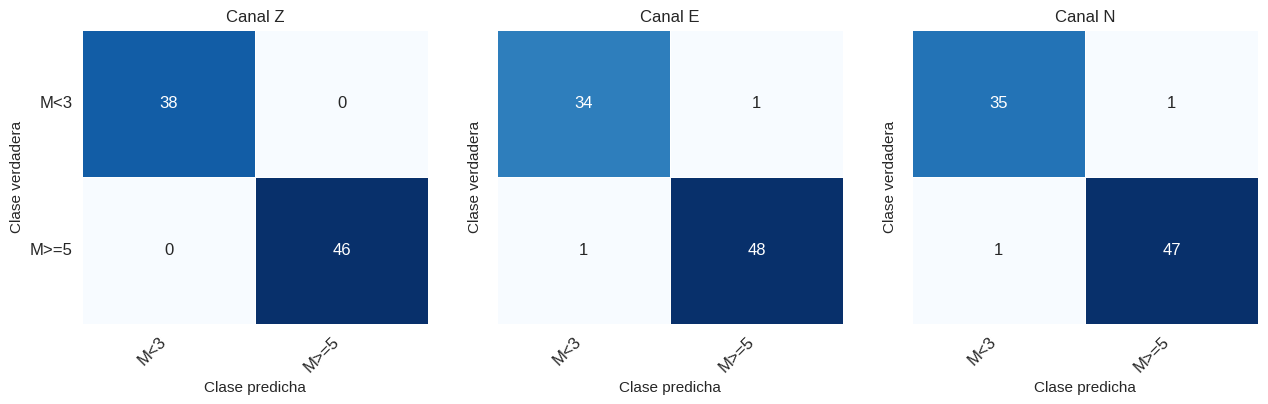

In [35]:
# Crear un mapa de calor de la matriz de confusión para el canal Z, E y N
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=False, gridspec_kw={'wspace': 0.2})

# Canal Z
heatmap_z = sns.heatmap(cm_Z, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax[0])
heatmap_z.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_z.set_yticklabels(classes, rotation=0, fontsize=12)
ax[0].set_title('Canal Z')
ax[0].set_xlabel('Clase predicha')
ax[0].set_ylabel('Clase verdadera')

# Canal E
heatmap_e = sns.heatmap(cm_E, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax[1])
heatmap_e.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_e.set_yticklabels([])  # Eliminar etiquetas del eje y
ax[1].set_title('Canal E')
ax[1].set_xlabel('Clase predicha')
ax[1].set_ylabel('Clase verdadera')

# Canal N con barra de colores
heatmap_n = sns.heatmap(cm_N, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax[2])
heatmap_n.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_n.set_yticklabels([])  # Eliminar etiquetas del eje y
ax[2].set_title('Canal N')
ax[2].set_xlabel('Clase predicha')
ax[2].set_ylabel('Clase verdadera')

#fig.colorbar(ax[1].collections[0], cax=ax[3])

# Ajustar el diseño para evitar superposiciones
plt.subplots_adjust(wspace=0.5)
plt.show()

## 1D

### Canal Z

Weights: [0.42951013 0.57048987]
Means: [26.53961347 31.00737388]
Covars: [[[0.5286135 ]]

 [[1.44912105]]]


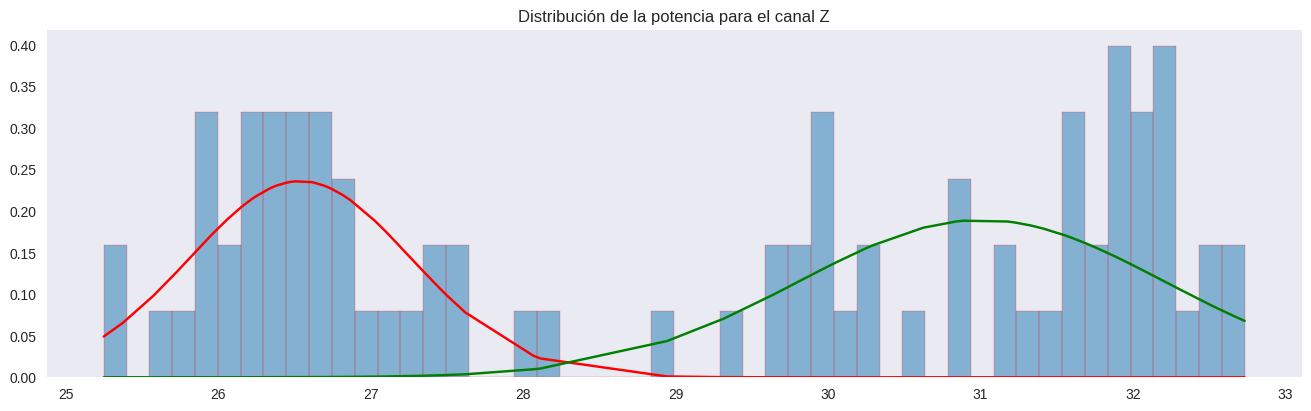

In [52]:
X_test_z = X_test_Z.squeeze()

f=X_test_z.reshape(-1,1)

weights_z = gmm_z.weights_
means_z = gmm_z.means_
covars_z = gmm_z.covariances_



x_axis = X_test_z
x_axis.sort()
print('Weights:', weights_z)
print('Means:', means_z.squeeze())
print('Covars:', covars_z)


fig, ax = plt.subplots(figsize=(13, 4))

ax.hist(f, bins=50, histtype='bar', density=True, ec='red', alpha=0.5)
ax.plot(x_axis,weights_z[0]*stats.norm.pdf(x_axis,means_z[0],np.sqrt(covars_z[0])).ravel(), c='red')
ax.plot(x_axis,weights_z[1]*stats.norm.pdf(x_axis,means_z[1],np.sqrt(covars_z[1])).ravel(), c='green')
ax.title.set_text('Distribución de la potencia para el canal Z')

ax.grid()
plt.show()



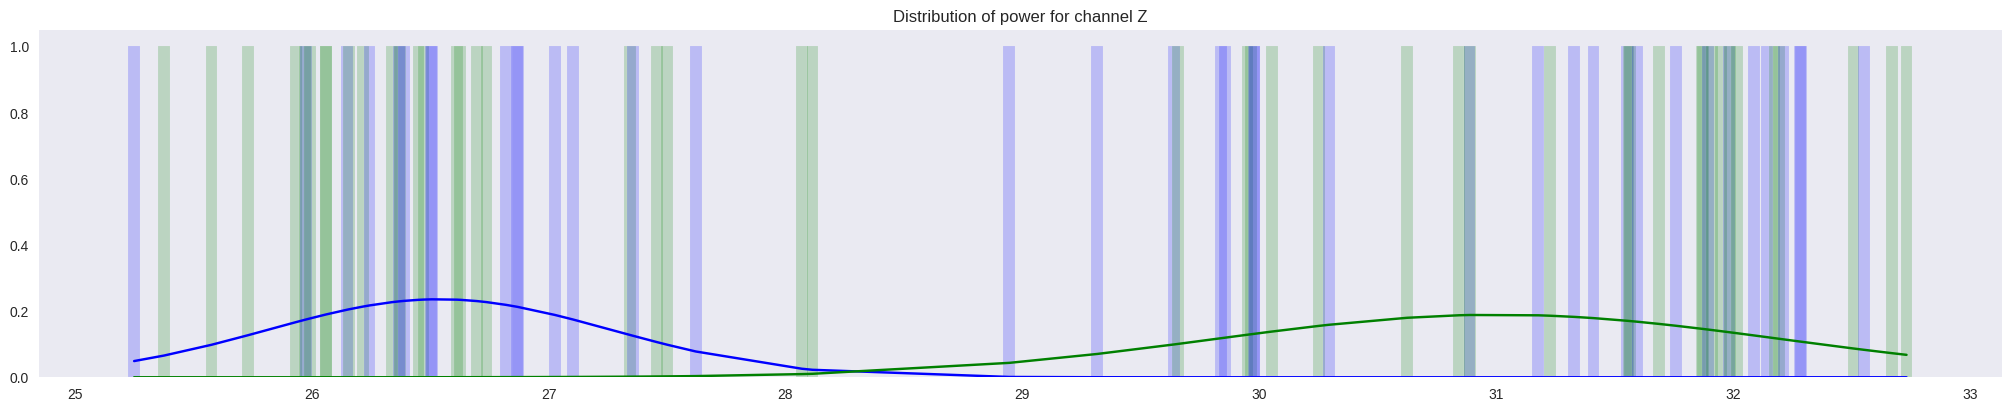

In [44]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 4))

# Individual bars for each data point
for i, x_val in enumerate(X_test_z):
    ax.bar(x_val, 1, color='blue' if labels_z[i] == 0 else 'green', alpha=0.2, width=0.05)

# Probability density curves
ax.plot(x_axis, weights_z[0] * stats.norm.pdf(x_axis, means_z[0], np.sqrt(covars_z[0])).ravel(), c='blue')
ax.plot(x_axis, weights_z[1] * stats.norm.pdf(x_axis, means_z[1], np.sqrt(covars_z[1])).ravel(), c='green')

# Title and grid
ax.set_title('Distribution of power for channel Z')
ax.grid()

# Show the plot
plt.show()

Weights: [0.52358891 0.47641109]
Means: [31.55725374 26.81201265]
Covars: [[[0.95972248]]

 [[0.83825911]]]


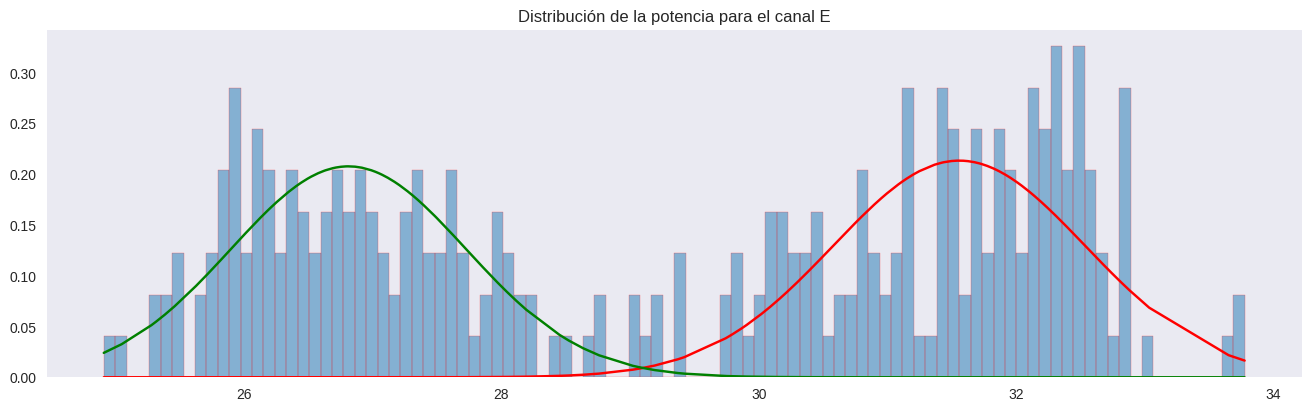

In [108]:
X_e = X_e.squeeze()

f=X_e.reshape(-1,1)

weights_e = gmm_e.weights_
means_e = gmm_e.means_
covars_e = gmm_e.covariances_



x_axis = X_e
x_axis.sort()
print('Weights:', weights_e)
print('Means:', means_e.squeeze())
print('Covars:', covars_e)


fig, ax = plt.subplots(figsize=(13, 4))

ax.hist(f, bins=100, histtype='bar', density=True, ec='red', alpha=0.5)
ax.plot(x_axis,weights_e[0]*stats.norm.pdf(x_axis,means_e[0],np.sqrt(covars_e[0])).ravel(), c='red')
ax.plot(x_axis,weights_e[1]*stats.norm.pdf(x_axis,means_e[1],np.sqrt(covars_e[1])).ravel(), c='green')
ax.title.set_text('Distribución de la potencia para el canal E')

ax.grid()
plt.show()


Error en el evento: 0
Etiqueta predicha: 0
Etiqueta verdadera: 1.0
Potencia: [29.0889505]
Error en el evento: 28
Etiqueta predicha: 1
Etiqueta verdadera: 0.0
Potencia: [29.19216583]


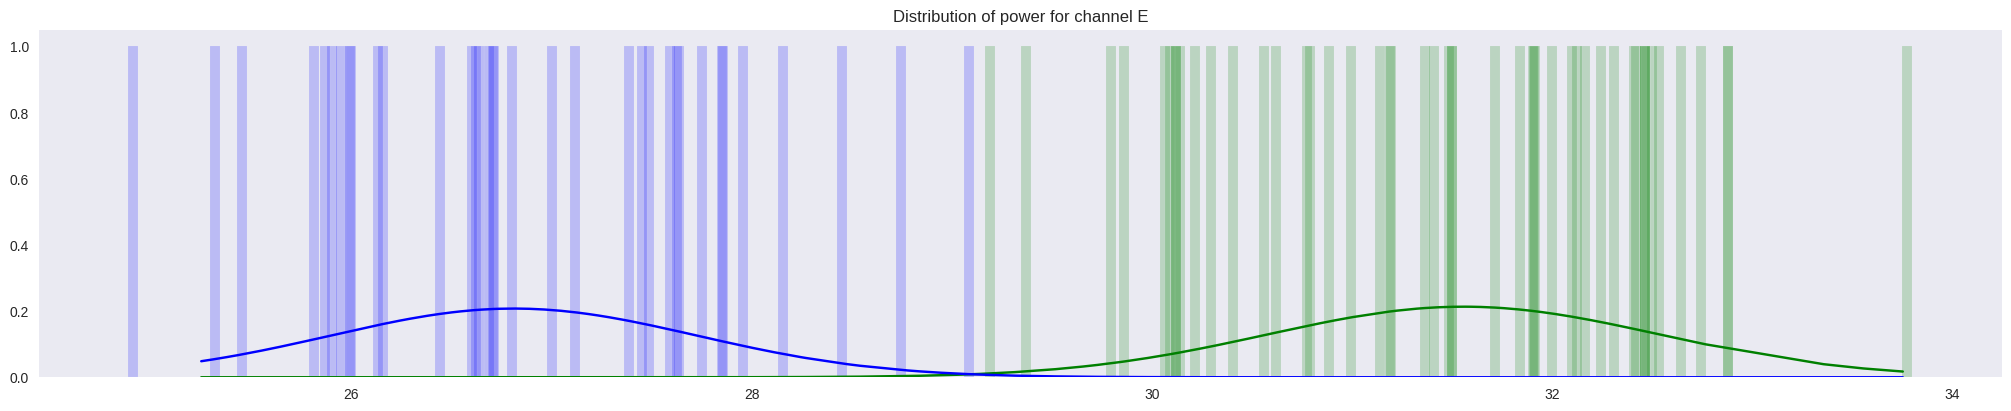

In [169]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 4))

# Individual bars for each data point
for i, x_val in enumerate(X_test_E):
    ax.bar(x_val, 1, color='blue' if labels_e[i] == 0 else 'green', alpha=0.2, width=0.05)
    if labels_e[i]!=y_test_E[i]:
        print('Error en el evento:', i)
        print('Etiqueta predicha:', labels_e[i])
        print('Etiqueta verdadera:', y_test_E[i])
        print('Potencia:', X_test_E[i])


# Probability density curves
ax.plot(x_axis, weights_e[0] * stats.norm.pdf(x_axis, means_e[0], np.sqrt(covars_e[0])).ravel(), c='green')
ax.plot(x_axis, weights_e[1] * stats.norm.pdf(x_axis, means_e[1], np.sqrt(covars_e[1])).ravel(), c='blue')

# Title and grid
ax.set_title('Distribution of power for channel E')
ax.grid()

# Show the plot
plt.show()

In [162]:
labels_e == y_test_E

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Weights: [0.54318837 0.45681163]
Means: [31.40809449 26.75342053]
Covars: [[[1.05792289]]

 [[0.77210761]]]


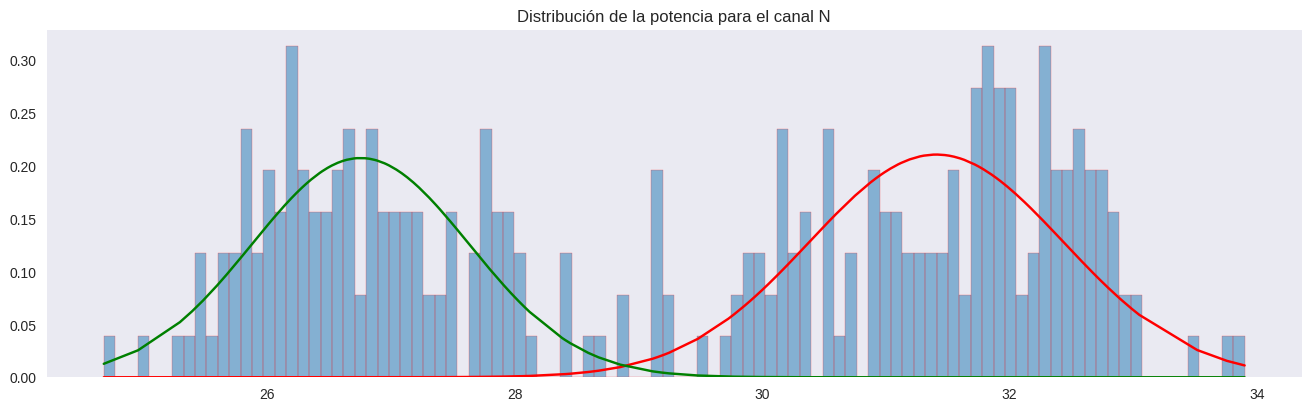

In [109]:
X_n = X_n.squeeze()

f=X_n.reshape(-1,1)

weights_n = gmm_n.weights_
means_n = gmm_n.means_
covars_n = gmm_n.covariances_



x_axis = X_n
x_axis.sort()
print('Weights:', weights_n)
print('Means:', means_n.squeeze())
print('Covars:', covars_n)


fig, ax = plt.subplots(figsize=(13, 4))

ax.hist(f, bins=100, histtype='bar', density=True, ec='red', alpha=0.5)
ax.plot(x_axis,weights_n[0]*stats.norm.pdf(x_axis,means_n[0],np.sqrt(covars_n[0])).ravel(), c='red')
ax.plot(x_axis,weights_n[1]*stats.norm.pdf(x_axis,means_n[1],np.sqrt(covars_n[1])).ravel(), c='green')
ax.title.set_text('Distribución de la potencia para el canal N')

ax.grid()
plt.show()


## 2D

In [ ]:
X = X[:, ::-1] # flip axes for better plotting


X_stretched = np.dot(X, rng.randn(2, 2))


from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                             angle, **kwargs))
        
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=7, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=7, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)       


plot_gmm(gmm, X_stretched)